In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxkan.models.KAN import KAN

def print_dict_hierarchy(d, indent=0):
    for key, value in d.items():
        if isinstance(value, dict):
            print(' ' * indent + str(key))
            print_dict_hierarchy(value, indent + 4)
        else:
            print(' ' * indent + f"{key}: shape {value.shape}")
            
key = jax.random.PRNGKey(0)

In [10]:
class KeyHandler:
    def __init__(self, seed: int):
        self._key = jax.random.PRNGKey(seed)
        
    def key(self):
        _, self._key = jax.random.split(self._key)
        return self._key
    
Handler = KeyHandler(0)
key = Handler.key()
# key

In [11]:
import optax
from tqdm.auto import tqdm

def loss_fn(params, x, y, state, model):
    def u(x):
        y, spl_reg = model.apply(variables, x)
        return y
    variables = {'params' : params, 'state' : state}
    y_hat = u(x)

    return jnp.mean((y_hat - y)**2)
    
def train_step(params, x, y, optimizer, opt_state, state, model):    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(params, x, y, state, model)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, loss, opt_state

In [12]:
N_INPUT = 2

layer_dims = [N_INPUT, 5, 2, 1]

n_splines = 3
model = KAN(layer_dims=layer_dims, k=n_splines, add_bias=True)

BS = 64
x = jax.random.normal(key, (BS, N_INPUT))
variables = model.init(key, x)

schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-3,  # Initial learning rate
    decay_steps=1000,  # Total number of decay steps
    alpha=0.1          # Final learning rate multiplier (alpha * initial value)
)
optimizer = optax.adam(learning_rate=schedule_fn)
# optimizer = optax.sgd(learning_rate=1e-4)
opt_state = optimizer.init(variables['params'])

print_dict_hierarchy(variables)

params
    bias_0: shape (5,)
    bias_1: shape (2,)
    bias_2: shape (1,)
    layers_0
        c_basis: shape (10, 6)
        c_spl: shape (10,)
        c_res: shape (10,)
    layers_1
        c_basis: shape (10, 6)
        c_spl: shape (10,)
        c_res: shape (10,)
    layers_2
        c_basis: shape (2, 6)
        c_spl: shape (2,)
        c_res: shape (2,)
state
    layers_0
        grid: shape (10, 10)
    layers_1
        grid: shape (10, 10)
    layers_2
        grid: shape (2, 10)


In [13]:
# functions to test KAN interpolation
@jax.jit
def bivariate_polynomial(x):
    y = x[0]**2 + x[1]**2
    return y

@jax.jit
def oscillatory_sine(x):
    freq = 3
    y = jnp.sin(freq * jnp.pi * x[0]) * jnp.cos(freq * jnp.pi * x[1])
    return y

@jax.jit
def checkerboard_function(x):
    y = jnp.sign(jnp.sin(3 * jnp.pi * x[0]) * jnp.sin(3 * jnp.pi * x[1]))
    return y

@jax.jit
def distance_function(x):
    y = jnp.sqrt((x[0] - 0.5)**2 + (x[1] - 0.5)**2)
    return y

@jax.jit
def piecewise_step_function(x):
    y = jnp.where(x[0] + x[1] > 1, 1.0, 0.0)
    return y

@jax.jit
def ring_function(x):
    freq = 4
    y = jnp.sin(freq * jnp.pi * jnp.sqrt((x[0] - 0.5)**2 + (x[1] - 0.5)**2))
    return y

@jax.jit
def modulated_gaussian(x):
    y = jnp.exp(-((x[0] - 0.5)**2 + (x[1] - 0.5)**2)) * jnp.sin(5 * jnp.pi * x[0]) * jnp.cos(5 * jnp.pi * x[1])
    return y

In [14]:
# choose a function
learnable_func = modulated_gaussian
ONLY_COLLOC = True

grid_extensions = {200: 5, 400: 10}
# grid_extensions = {}

MINVAL=0.
MAXVAL=1.

# all the points that will be trained on
T = 2000
colloc = jax.random.uniform(Handler.key(), (T, N_INPUT), minval=MINVAL, maxval=MAXVAL)

N = 1000
losses = []
for i in (pbar:= tqdm(range(N))):
    if ONLY_COLLOC: # sample initially and get subset in each step
        x = jax.random.choice(Handler.key(), colloc, (BS,), replace=False)
    else: # sample every step
        x = jax.random.uniform(Handler.key(), (BS, N_INPUT), minval=MINVAL, maxval=MAXVAL)
    
    y = jax.vmap(learnable_func, (0))(x)
    y = y.reshape(-1,1)
    
    params, state = variables['params'], variables['state']
    params, loss, opt_state = train_step(params, x, y, optimizer, opt_state, state, model)
    # update params
    variables = {'params': params, 'state': state}
    
    pbar.set_description(f"Loss {loss: .4f}")
    losses.append(loss)
    
    if i in grid_extensions:
        # update grid to use 2 more splines in each grid
        n_splines = grid_extensions[i]
        
        updated_variables = model.apply(variables, x, n_splines, method=model.update_grids)
        variables = updated_variables.copy()
        # reset opt state, dirty solution
        opt_state = optimizer.init(variables['params'])

  0%|          | 0/1000 [00:00<?, ?it/s]

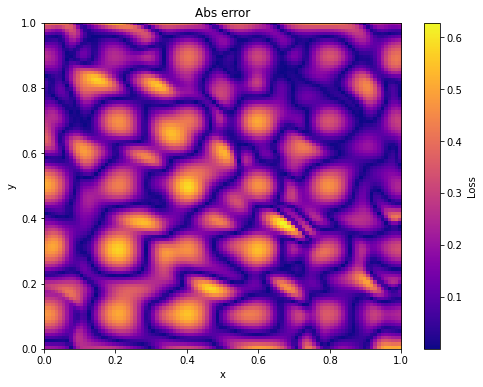

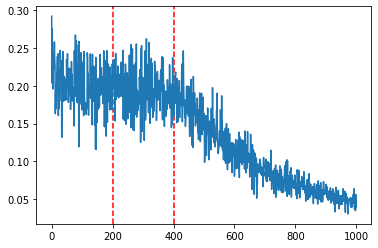

In [15]:
def plot_heatmap(arr, title):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(MINVAL, MAXVAL, MINVAL, MAXVAL), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

N = 100

X_1 = jnp.linspace(MINVAL, MAXVAL, N)
X_2 = jnp.linspace(MINVAL, MAXVAL, N)
X_1, X_2 = jnp.meshgrid(X_1, X_2, indexing='ij')
coords = jnp.stack([X_1.flatten(), X_2.flatten()], axis=1)
y = jax.vmap(learnable_func, (0))(coords).reshape(-1,1)

y_hat, regs = model.apply(variables, coords)
error = jnp.abs(y - y_hat).reshape(N, N)

plot_heatmap(error, "Abs error")
# plot_heatmap(error / (y.mean() + 1e-16), "Relative error")

grid_extensions = {200: 5, 400: 10}
for index in grid_extensions.keys():
    plt.axvline(x=index, color='red', linestyle='--')
plt.plot(losses)

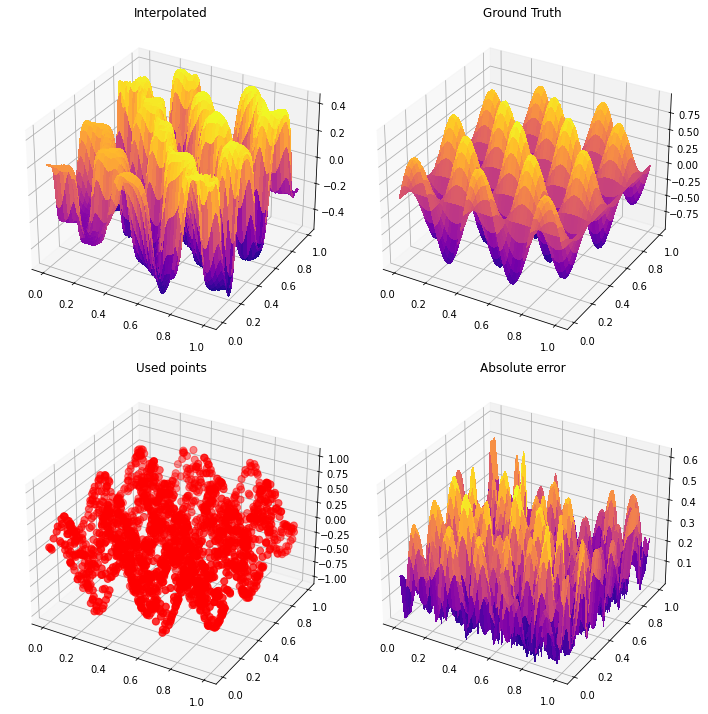

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_3d_surfaces(X_1, X_2, p1, p2, p4, colloc_points=None, title1='Surface 1', title2='Surface 2', figsize=(10, 10)):
    """
    Plots two 3D surface plots side by side and overlays collocation points.

    Parameters:
    - X_1: 2D array for X-axis values.
    - X_2: 2D array for Y-axis values.
    - error1: 2D array for Z-axis values of the first surface.
    - error2: 2D array for Z-axis values of the second surface.
    - collocation_points: Tuple containing X, Y, Z coordinates of collocation points.
    - title1: Title for the first surface plot.
    - title2: Title for the second surface plot.
    - figsize: Size of the figure (width, height).
    """
    # Create a larger figure with 2 subplots
    fig = plt.figure(figsize=figsize)  # Set the figure size

    # First subplot
    ax1 = fig.add_subplot(221, projection='3d')
    surf1 = ax1.plot_surface(X_1, X_2, p1, cmap=cm.plasma, linewidth=0, antialiased=False)
    ax1.set_title('Interpolated')  # Set title for the first subplot

    # Second subplot
    ax2 = fig.add_subplot(222, projection='3d')
    surf2 = ax2.plot_surface(X_1, X_2, p2, cmap=cm.plasma, linewidth=0, antialiased=False)
    ax2.set_title('Ground Truth')  # Set title for the second subplot

    # Plot collocation points
    ax3 = fig.add_subplot(223, projection='3d')
    colloc_x = colloc_points[:, 0]  # X-coordinates
    colloc_y = colloc_points[:, 1]  # Y-coordinates
    colloc_z1 = jax.vmap(learnable_func, (0))(colloc_points)  # Z values for surface 1
    ax3.scatter(colloc_x, colloc_y, colloc_z1, color='red', s=50)
    ax3.set_title('Used points')  # Set title for the second subplot
    
    # Plot collocation points
    ax4 = fig.add_subplot(224, projection='3d')
    surf4 = ax4.plot_surface(X_1, X_2, p4, cmap=cm.plasma, linewidth=0, antialiased=False)
    ax4.set_title('Absolute error')
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    
plot_3d_surfaces(X_1, X_2, y_hat.reshape(N, N), y.reshape(N, N), error, colloc)